<a href="https://colab.research.google.com/github/malcolmrite-dsi/JSE_Researcher/blob/main/Stock_Price_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [ ]:
!pip install nsepy

https://www.analyticsvidhya.com/blog/2020/11/stock-market-price-trend-prediction-using-time-series-forecasting/

In [47]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pmdarima.arima.utils import ndiffs

from statsmodels.tsa.stattools import acf
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

# Importing Training Data

In [2]:
top40 = pd.read_csv("drive/MyDrive/TOP40_company_list.csv")

In [3]:
top40.head()

,Share Code,Short Name
0,ABG,ABSA
1,ARI,ARM
2,AMS,AMPLATS
3,AGL,ANGLO
4,ANG,ANGGOLD


In [4]:
train_df = pd.DataFrame(columns=["Date",	"Open",	"High"	,"Low"	,"Close",	"Adj Close",	"Volume", "Code"])
for code in top40["Share Code"]:
  df = pd.read_csv(f"drive/MyDrive/Kaggle dataset/{code}.JO.csv")
  df["Code"] = code
  frames = [train_df, df]
  train_df = pd.concat(frames)

train_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Code
2995,2021-01-07,12400.0,12637.0,12285.0,12601.0,12601.0,1222189,VOD
2996,2021-01-08,12680.0,13219.0,12550.0,13188.0,13188.0,2796671,VOD
2997,2021-01-11,12800.0,13261.0,12906.0,12986.0,12986.0,2185762,VOD
2998,2021-01-12,13010.0,12989.0,12759.0,12953.0,12953.0,1545602,VOD
2999,2021-01-13,12759.0,13248.0,12846.0,12932.0,12932.0,2137728,VOD


# Exploratory Data Analysis

In [5]:
train_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Code
0,2000-01-04,2760.0,2830.0,2745.0,2785.0,1224.745361,869505,ABG
1,2000-01-05,2700.0,2755.0,2650.0,2720.0,1196.160889,616931,ABG
2,2000-01-06,2720.0,2740.0,2680.0,2695.0,1185.166626,214315,ABG
3,2000-01-07,2695.0,2800.0,2695.0,2790.0,1226.944214,1290643,ABG
4,2000-01-10,2810.0,3025.0,2810.0,2950.0,1297.306641,3630720,ABG


In [6]:
train_df.describe()

,Open,High,Low,Close,Adj Close
count,153459.000000,153459.000000,153459.000000,153459.000000,153459.000000
mean,18209.652775,18474.976964,17935.523983,18206.519646,15641.079111
std,28117.951627,28486.272447,27728.821578,28101.766936,27472.107770
min,28.490000,29.330000,2.000000,29.230000,29.230000
25%,3787.199951,3845.620117,3729.830078,3785.000000,2761.094116
50%,10500.000000,10665.000000,10326.900391,10500.000000,7688.450684
75%,21250.000000,21552.000000,20935.000000,21250.000000,17150.972657
max,349001.000000,349945.000000,334002.000000,344308.000000,343680.218750


In [7]:
train_df.Date = train_df.Date.astype("datetime64")
train_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Code
0,2000-01-04,2760.0,2830.0,2745.0,2785.0,1224.745361,869505,ABG
1,2000-01-05,2700.0,2755.0,2650.0,2720.0,1196.160889,616931,ABG
2,2000-01-06,2720.0,2740.0,2680.0,2695.0,1185.166626,214315,ABG
3,2000-01-07,2695.0,2800.0,2695.0,2790.0,1226.944214,1290643,ABG
4,2000-01-10,2810.0,3025.0,2810.0,2950.0,1297.306641,3630720,ABG


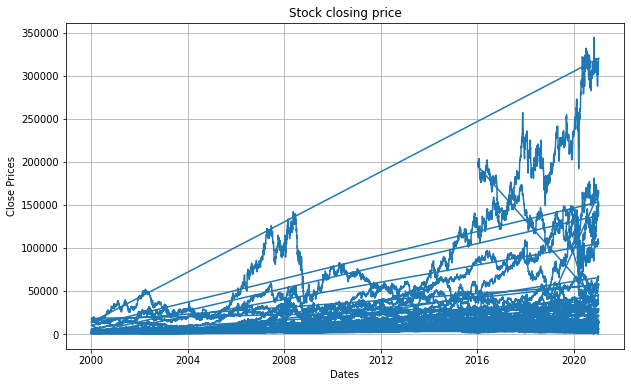

In [8]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(train_df.Date, train_df['Close'])
plt.title('Stock closing price')
plt.show()

# Feature Engineering

In [9]:
train_df.Volume = train_df.Volume.astype("int")

In [11]:
#Find all unique codes
unique = train_df.iloc[:,-1].unique()
print(len(unique))

listofDF = []
dataF = train_df.groupby(train_df.iloc[:,-1])
for value in unique:
  listofDF.append(dataF.get_group(value))

d = {}
for i in range(len(listofDF)):
    d[unique[i]] = listofDF[i]

d["ABG"].head()

40


,Date,Open,High,Low,Close,Adj Close,Volume,Code
0,2000-01-04,2760.0,2830.0,2745.0,2785.0,1224.745361,869505,ABG
1,2000-01-05,2700.0,2755.0,2650.0,2720.0,1196.160889,616931,ABG
2,2000-01-06,2720.0,2740.0,2680.0,2695.0,1185.166626,214315,ABG
3,2000-01-07,2695.0,2800.0,2695.0,2790.0,1226.944214,1290643,ABG
4,2000-01-10,2810.0,3025.0,2810.0,2950.0,1297.306641,3630720,ABG


In [ ]:
train_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Code
5416,2021-01-13,45060.0,45413.0,44679.0,44679.0,44679.0,1918831,BHP
3018,2021-01-13,9598.0,9598.0,9365.0,9436.0,9436.0,1545993,NRP
223,2021-01-13,6305.0,6410.0,6270.0,6316.0,6316.0,10705047,SSW
781,2021-01-13,27801.0,28999.0,28197.0,28910.0,28910.0,254316,RNI
2999,2021-01-13,12759.0,13248.0,12846.0,12932.0,12932.0,2137728,VOD


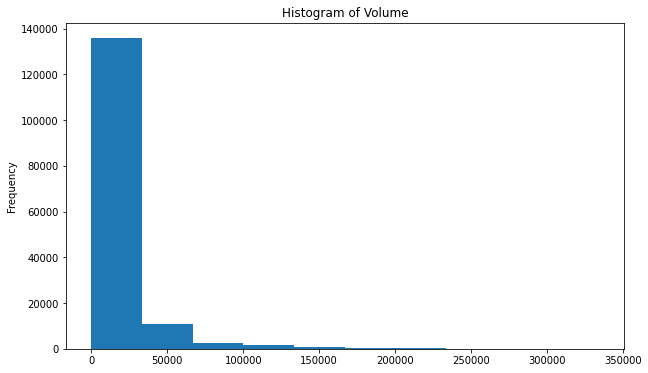

In [ ]:
plt.figure(figsize=(10,6))
df_vol = train_df['Low']
df_vol.plot(style='k.',kind='hist')
plt.title('Histogram of Volume')
plt.show()

In [ ]:
train_df.Close.shift(1)

0               NaN
0        2785.00000
0         890.00000
0        2500.00000
0        1021.01001
           ...     
5416    38552.00000
3018    44679.00000
223      9436.00000
781      6316.00000
2999    28910.00000
Name: Close, Length: 153459, dtype: float64

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

for code in top40["Share Code"]:
  test_stationarity(d[code].Close)

# Logging the Data

In [18]:
from pylab import rcParams

In [ ]:
for code in top40["Share Code"]:
  rcParams['figure.figsize'] = 10, 6
  df_log = np.log(d[code].Close)
  moving_avg = df_log.rolling(12).mean()
  std_dev = df_log.rolling(12).std()
  plt.legend(loc='best')
  plt.title('Moving Average')
  plt.plot(std_dev, color ="black", label = "Standard Deviation")
  plt.plot(moving_avg, color="red", label = "Mean")
  plt.legend()
  plt.show()

# Splitting the Test and Train DataSets

https://pypi.org/project/pmdarima/

In [ ]:

for code in top40["Share Code"]:
  df_log = np.log(d[code].Close)
  train_data, test_data = df_log[:int(len(df_log))], df_log[int(len(df_log)*0.95):]
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.xlabel('Dates')
  plt.ylabel('Closing Prices')
  plt.plot(train_data, 'green', label='Train data')
  plt.plot(test_data, 'blue', label='Test data')
  plt.legend()
  plt.show()

  model_autoARIMA = auto_arima(train_data, m=1)

  # make your forecasts
  forecasts = model_autoARIMA.predict(test_data.shape[0])  # predict N steps into the future

  # Visualize the forecasts (blue=train, green=forecasts)

  x = np.arange(df_log.shape[0])
  plt.plot(x[:int(len(df_log))], train_data, c='blue')
  plt.plot(x[int(len(df_log)*0.95):], forecasts, c='green')
  plt.show()

  # Serialize your model just like you would in scikit:
  with open(f'drive/MyDrive/Stock Price Models/{code}_model.pkl', 'wb') as pkl:
      pickle.dump(model_autoARIMA, pkl)
